# Project 3
## clustering, dimensionality reduction, and non-monotonous neurons

### Members:
* Akhilesh Vyas
* Pooja Bhatia
* Asif Altaf 
* Abakar Bouba
* Mehdi Ali
* Seyithan Dag
* Mihail Luchian
* Muhammad Hassan Farooq
* Utkrist Adhikari
* Julian Tanke
* Omid Najaee Nezhad
* Hosam Alqaderi

### 3.1 fun with k-means clustering

Plot the data, then implement
* Llyoyd's algorithm for k-means clustering
* Hartigan's algorithm for k-means clustering
* MacQueen's algorithm for k-means clustering

for k=3 run and plot.

/root/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


COSTS:
	Llyod's:	 0.018963336944580078
	Hartigan:	 0.021174192428588867
	MacQueen:	 0.002299070358276367


/root/miniconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


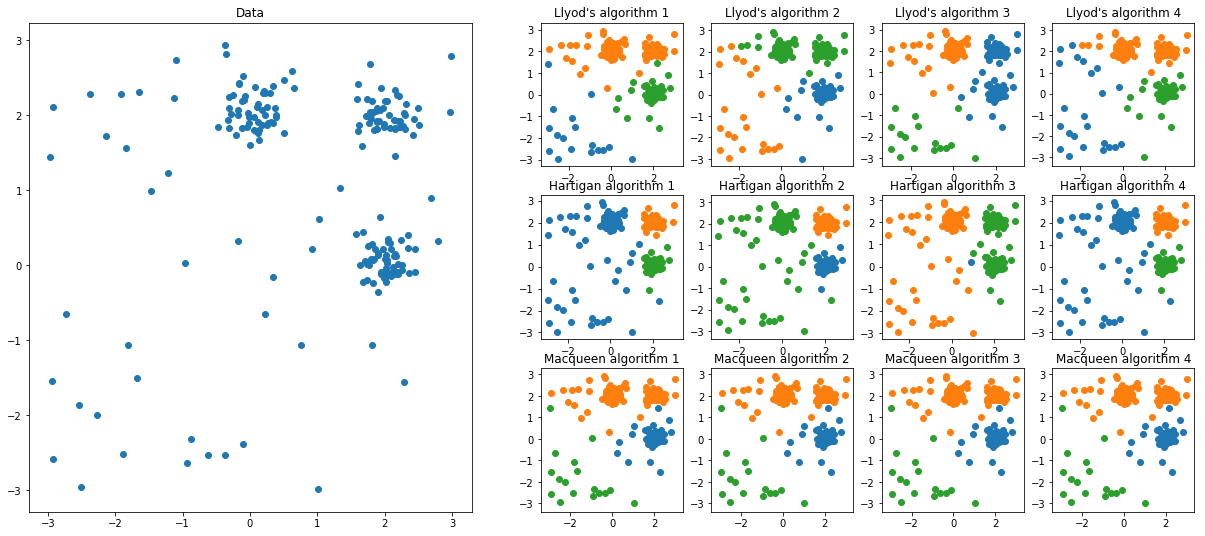

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import randint
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy.linalg as la
import sys
from time import time
import scipy

from scipy.cluster.vq import kmeans2

data = genfromtxt('data-clustering-1.csv', delimiter=',', dtype=np.float32)
x, y = data[0,:], data[1,:]

# ----------- Lloyd ---------------
def lloyd(data, k=3):
    return kmeans2(data, k)

# ---------- Hartigan -------------
def hartigan(data, K=3):
    # randomly assign to cluster
    n,m = data.shape
    labels = randint(0, K, n)
    
    def E(data, labels):
        """ Cost function
        """
        total_cost = 0
        for k in range(K):
            data_k = data[(labels == k).nonzero()]
            mu_k = np.mean(data_k, 0)
            cost_k = la.norm(data_k - mu_k)
            total_cost += cost_k
        return total_cost
    
    converged = False
    while not converged:
        converged = True
        
        for j in range(n):
            C_i = labels[j]
            
            min_cost = E(data, labels)
            C_w = C_i
            
            for k in range(K):
                if k == C_i:
                    continue
                labels[j] = k
                cost = E(data, labels)
                if cost < min_cost:
                    min_cost = cost
                    C_w = k
            
            if C_w != C_i:
                converged = False
            
            labels[j] = C_w
    
    # calculate mean for all clusters
    mu = [np.mean(data[(labels == k).nonzero()], 0) for k in range(K)]
    
    return mu, labels
        

# --------- MacQueen --------------
def macqueen(data, K=3):
    n, m = data.shape
    C = [0] * K
    N = [0] * K
    labels = np.zeros((n,))
    Mu = np.zeros((K, m))
    
    for j, x in enumerate(data):
        min_cost = sys.float_info.max
        w = -1
        for k in range(K):
            cost = la.norm(x - Mu[k])
            if min_cost > cost:
                min_cost = cost
                w = k
        assert w > -1
        N[w] += 1
        Mu[w] += 1/N[w] * (x - Mu[w])
        labels[j] = w
    
    return Mu, labels

# -------- plotting ---------------
fig = plt.figure(figsize=(27, 9))
ax = fig.add_subplot(131)
ax.set_title('Data')
ax.scatter(x, y)
# --

def plot_algorithm(ax, data, algorithm, title):
    centers, labels = algorithm(data.T)
    locs_a, locs_b, locs_c =\
    (labels == 0).nonzero(), (labels == 1).nonzero(), (labels == 2).nonzero()
    ax.scatter(x[locs_a], y[locs_a])
    ax.scatter(x[locs_b], y[locs_b])
    ax.scatter(x[locs_c], y[locs_c])
    ax.set_title(title)

plot_algorithm(fig.add_subplot(3,9,4), data, lloyd, 'Llyod\'s algorithm 1')
plot_algorithm(fig.add_subplot(3,9,5), data, lloyd, 'Llyod\'s algorithm 2')
plot_algorithm(fig.add_subplot(3,9,6), data, lloyd, 'Llyod\'s algorithm 3')
plot_algorithm(fig.add_subplot(3,9,7), data, lloyd, 'Llyod\'s algorithm 4')

plot_algorithm(fig.add_subplot(3,9,13), data, hartigan, 'Hartigan algorithm 1')
plot_algorithm(fig.add_subplot(3,9,14), data, hartigan, 'Hartigan algorithm 2')
plot_algorithm(fig.add_subplot(3,9,15), data, hartigan, 'Hartigan algorithm 3')
plot_algorithm(fig.add_subplot(3,9,16), data, hartigan, 'Hartigan algorithm 4')

plot_algorithm(fig.add_subplot(3,9,22), data, macqueen, 'Macqueen algorithm 1')
plot_algorithm(fig.add_subplot(3,9,23), data, macqueen, 'Macqueen algorithm 2')
plot_algorithm(fig.add_subplot(3,9,24), data, macqueen, 'Macqueen algorithm 3')
plot_algorithm(fig.add_subplot(3,9,25), data, macqueen, 'Macqueen algorithm 4')


def calculate_runtime(data, algorithm, runs=20):
    __start = time()
    for i in range(20):
        algorithm(data)
    __end = time()
    return __end - __start

print("COSTS:")
print("\tLlyod's:\t", calculate_runtime(data, lloyd))
print("\tHartigan:\t", calculate_runtime(data, hartigan))
print("\tMacQueen:\t", calculate_runtime(data, macqueen))

plt.show()

### 3.2: spectral clustering


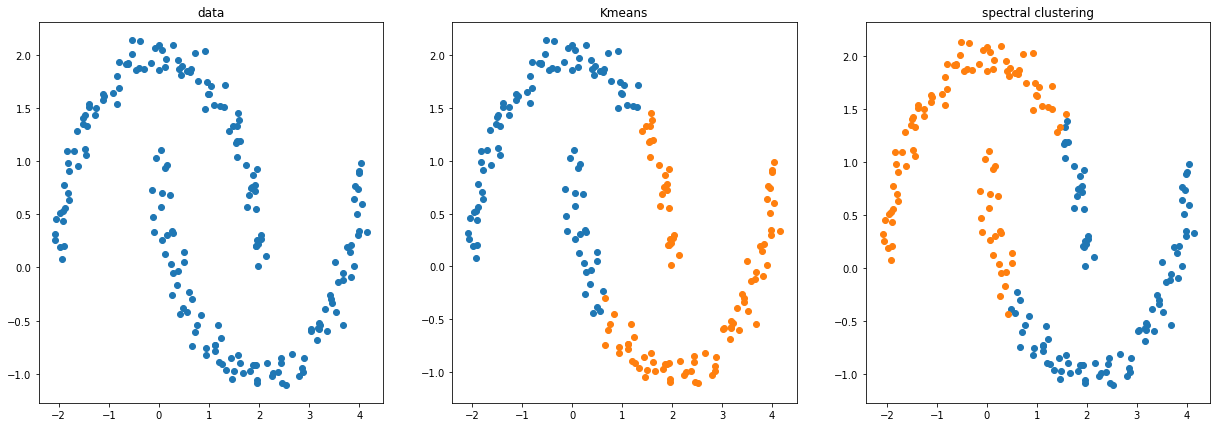

In [2]:
%matplotlib inline
import numpy as np
from numpy.random import randint
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy.linalg as la
import sys
from time import time
import scipy
import sklearn.metrics as mt


#help(mt.pairwise_distances)

from scipy.cluster.vq import kmeans2

data = genfromtxt('data-clustering-2.csv', delimiter=',', dtype=np.float32)
x, y = data[0,:], data[1,:]

# ---------- kmeans -------------
_, labels_kmeans = kmeans2(data.T, 2)

# --- spectral clustering -------
def spectral_clustering(data):
    """ k is always 2 in this case
    """
    beta = 1
    S = np.exp(-beta * mt.pairwise_distances(data.T, metric='euclidean'))
    D = np.diag(np.sum(S, axis=0))
    L = D - S
    
    w,v = la.eig(L)  # eigenvalues are not necessarily sorted!!
    
    # get second-smallest
    w[np.argmin(w)] = sys.float_info.max
    u2 = v[:,np.argmin(w)]  # 2. smallest eigenvalue
    
    labels = (u2 > 0) * 1
    return labels
    
labels_sc = spectral_clustering(data)
    
# ----------- plot --------------
def plot_algorithm(ax, data, labels, title):
    locs_a, locs_b = (labels == 0).nonzero(), (labels == 1).nonzero()
    ax.scatter(x[locs_a], y[locs_a])
    ax.scatter(x[locs_b], y[locs_b])
    ax.set_title(title)


fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131)
ax.scatter(x, y)
ax.set_title('data')

plot_algorithm(fig.add_subplot(132), data, labels_kmeans, 'Kmeans')
plot_algorithm(fig.add_subplot(133), data, labels_sc, 'spectral clustering')

plt.show()